In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import os
import string
import spacy
import math
import networkx as nx
import unicodedata
import unidecode
import openai
from openai import OpenAI


from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud
from itertools import combinations
from scipy import stats
from collections import defaultdict
from flair.data import Sentence
from flair.models import SequenceTagger
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline
from textstat import textstat
import hide_code
import ast
import json

from spacy.lang.es.stop_words import STOP_WORDS

In [2]:
nlp = spacy.load("es_core_news_lg")

In [3]:
df = pd.read_excel("../datasets/exploration_datasets/silver/silver_df_news_balanced_df.xlsx")

In [4]:
df.head()

,title,category,content,country,newspaper,content_unicode,content_removed_unwanted_elements,content_lowercase,content_sentence_tokenization,content_lowercase_with_no_punctuation,content_without_stopwords,content_tokens,content_lemmes
0,¿Qué enfermedad sufrió Gabriel García Márquez ...,cultura,Se cumplen 10 años desde que ‘Gabo’ falleció.....,Colombia,Semana,Se cumplen 10 años desde que ‘Gabo’ falleció...,Se cumplen 10 anos desde que Gabo fallecio.. E...,se cumplen 10 anos desde que gabo fallecio.. e...,['se cumplen 10 anos desde que gabo fallecio.....,se cumplen 10 anos desde que gabo fallecio el ...,cumplen 10 anos gabo fallecio mundo letras vis...,cumplen 10 anos gabo fallecio mundo letras vis...,"['cumplir', 'ano', 'gabo', 'fallecio', 'mundo'..."
1,"“Tiburón: la historia de un clásico”, el docum...",cultura,"A medio siglo de su estreno, Tiburón vuelve a ...",Colombia,La El Colombiano,"A medio siglo de su estreno, Tiburón vuelve a...","A medio siglo de su estreno, Tiburon vuelve a ...","a medio siglo de su estreno, tiburon vuelve a ...","['a medio siglo de su estreno, tiburon vuelve ...",a medio siglo de su estreno tiburon vuelve a e...,siglo estreno tiburon vuelve escena documental...,siglo estreno tiburon vuelve escena documental...,"['siglo', 'estreno', 'tiburon', 'vuelve', 'esc..."
2,El “boom” de la literatura latinoamericana rev...,cultura,Décadas después del movimiento que convirtió a...,Colombia,Semana,Décadas después del movimiento que convirtio...,Decadas despues del movimiento que convirtio a...,decadas despues del movimiento que convirtio a...,['decadas despues del movimiento que convirtio...,decadas despues del movimiento que convirtio a...,decadas movimiento convirtio realismo magico s...,decadas movimiento convirtio realismo magico s...,"['decada', 'movimiento', 'convirtio', 'realism..."
3,Colombia brilló en Cannes: ‘Un Poeta’ ganó el ...,cultura,La película de Simón Mesa Soto fue galardonada...,Colombia,Semana,La película de Simón Mesa Soto fue galardona...,La pelicula de Simon Mesa Soto fue galardonada...,la pelicula de simon mesa soto fue galardonada...,['la pelicula de simon mesa soto fue galardona...,la pelicula de simon mesa soto fue galardonada...,pelicula simon mesa soto galardonada seccion m...,pelicula simon mesa soto galardonada seccion m...,"['pelicula', 'simon', 'mesa', 'soto', 'galardo..."
4,Este domingo en la FILBo habrá taller familiar...,cultura,"Será un espacio para leer, soñar, reír y refle...",Colombia,Semana,"Será un espacio para leer, soñar, reír y re...","Sera un espacio para leer, sonar, reir y refle...","sera un espacio para leer, sonar, reir y refle...","['sera un espacio para leer, sonar, reir y ref...",sera un espacio para leer sonar reir y reflexi...,espacio leer sonar reir reflexionar respeto em...,espacio leer sonar reir reflexionar respeto em...,"['espacio', 'leer', 'sonar', 'reir', 'reflexio..."


In [5]:
def remove_si_tiene_interes_block(text, domains=None):
    """Remove the 'Si tiene interés...' block robustly, even with malformed emails."""
    if domains is None:
        domains = ["elespectador.com"]

    start_match = re.search(r"Si\s+tiene\s+inter[eé]s", text, flags=re.IGNORECASE)
    if not start_match:
        return text  # nothing to remove

    start_idx = start_match.start()

    last_domain_pos = -1
    last_domain_len = 0
    for d in domains:
        for m in re.finditer(re.escape(d), text[start_idx:], flags=re.IGNORECASE):
            pos = start_idx + m.start()
            if pos > last_domain_pos:
                last_domain_pos = pos
                last_domain_len = len(d)

    if last_domain_pos != -1:
        search_start = last_domain_pos + last_domain_len
        period_match = re.search(r"\.", text[search_start:])
        end_idx = search_start + period_match.end() if period_match else len(text)
    else:
        period_match = re.search(r"\.", text[start_idx:])
        end_idx = start_idx + period_match.end() if period_match else len(text)

    cleaned = text[:start_idx] + " " + text[end_idx:]
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    return cleaned


def extract_text_without_unwanted_elements(text):
    """
    Cleans text:
    - Removes AI audio text and timestamps
    - Removes 'Lea más sobre...' and 'Si tiene interés...' blocks
    - Removes URLs, emojis, and non-breaking spaces
    - Keeps punctuation, bullet points, and Spanish accents
    """

    # 1️ Remove audio fragments and timestamps
    text = re.sub(
        r"(?:Audio\s+generado\s+con\s+IA\s+de\s+Google[\s\S]{0,200}?(?:\d{1,2}:\d{2}\s*(?:/|\n/\n|\u2215)\s*\d{1,2}:\d{2})?)",
        " ",
        text,
        flags=re.IGNORECASE,
    )
    text = re.sub(r"\d{1,2}:\d{2}\s*(?:/|\n/\n|\u2215)\s*\d{1,2}:\d{2}", " ", text)

    # 2️ Replace non-breaking spaces
    text = text.replace("\xa0", " ")

    # 3 Remove “Lea más sobre...” and “Le puede interesar...” sentences
    text = re.sub(r"(Lea\s+m[aá]s\s+sobre|Le\s+puede\s+interesar)[^.]*\.", " ", text, flags=re.IGNORECASE)

    # 4️ Remove URLs
    text = re.sub(r"http\S+|www\S+", " ", text)

    # 5️ Remove the “Si tiene interés…” block
    text = remove_si_tiene_interes_block(text, domains=["elespectador.com"])

    # 6️ Remove unwanted characters but KEEP accents, punctuation, and bullets
    text = re.sub(r"[^A-Za-zÁÉÍÓÚáéíóúÑñÜü0-9\s.,;:!?¿¡\"'()\-]", "", text)

    # 7️ Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # 8️ Normalize multiple punctuation
    text = re.sub(r"\.{2,}", ".", text)       # collapse ".." or "..."
    text = re.sub(r"([!?;:]){2,}", r"\1", text)

    return text



In [6]:
def extract_entities_spacy(text):
    """
    Extract (entity_text, entity_label) pairs from Spanish text,
    keeping original casing for model use.
    """
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        ent_text = ent.text.strip()
        words = [w.strip(string.punctuation).lower() for w in ent_text.split()]
        if len(words) == 0 or all(word in STOP_WORDS for word in words):
            continue
        if len(ent_text) <= 3:
            continue
        # Keep original text (with case)
        entities.append((ent.text.strip(), ent.label_))
    return entities


In [7]:
REMOVE_WORDS = {
    # Basic connectors and determiners
    "de", "del", "la", "las", "el", "los", "y", "a", "en", "al",
    "para", "por", "con", "sin", "sobre", "tras", "entre", "hacia", "hasta",
    "desde", "ante", "bajo", "según", "segun",

    # Articles and pronouns
    "un", "una", "unos", "unas", "lo", "su", "sus", "tu", "tus",
    "mi", "mis", "nuestro", "nuestra", "nuestros", "nuestras",
    "vuestro", "vuestra", "vuestros", "vuestras",
    "este", "esta", "estos", "estas", "ese", "esa", "esos", "esas",
    "aquel", "aquella", "aquellos", "aquellas", "ello",

    # Common verbs (frequent and low semantic value)
    "ser", "es", "era", "eran", "fue", "fueron", "soy", "eres", "somos", "son",
    "estar", "está", "estan", "están", "estaba", "estaban", "estuve", "estuvieron",
    "haber", "hay", "había", "habían", "he", "han", "ha", "haya", "habrá", "habrían",
    "tener", "tiene", "tienen", "tenía", "tenían", "tuvo", "tuvieron", "tendría",
    "hacer", "hace", "hacen", "hacía", "hacían", "hizo", "hicieron", "hará", "harían",
    "poder", "puede", "pueden", "podía", "podían", "podrá", "podrían", "eso"

    # Common functional words
    "que", "se", "ya", "no", "ni", "sí", "si", "tambien", "también",
    "solo", "sólo", "muy", "más", "mas", "menos", "todo", "toda", "todos", "todas",
    "nada", "algo", "algún", "alguna", "algunos", "algunas",
    "cual", "cuál", "cuales", "cuáles", "quien", "quién", "quienes", "quiénes",
    "donde", "dónde", "cuando", "cuándo", "como", "cómo",
    "porque", "porqué", "ya", "entonces", "así", "mismo", "además", "aunque",
    "pero", "sin embargo", "incluso", "también", "pues", "aun", "aún",

    # Filler and journalist/reporting words
    "lea", "lea tambien", "lea también", "según", "segun", "afirmó", "dijo",
    "indicó", "explicó", "comentó", "aseguró", "manifestó", "informó",
    "sostuvo", "declaró", "añadió", "agregó", "señaló", "destacó",
    "recordó", "resaltó", "consideró", "precisó", "recalcó",
    "dicha", "dicho", "asimismo", "finalmente", "actualmente",
    "cabe", "destaca", "afirmó", "indicó", "agregó",

    # Pronouns and reflexives
    "me", "te", "se", "nos", "os", "le", "les", "la", "lo", "las", "los",
    "él", "ella", "ellos", "ellas", "usted", "ustedes", "nosotros", "vosotros",

    # Miscellaneous and temporal words
    "yo", "tú", "usted", "él", "ella", "ellos", "ellas",
    "alguien", "cualquiera", "ninguno", "ninguna", "nunca",
    "siempre", "ahora", "ayer", "hoy", "mañana", "ahí", "aquí", "allí", "allá",
    "entonces", "mientras", "durante", "antes", "después",

    # Common noisy/filler words in scraped news text
    "siga leyendo", "según", "segun", "acuerdo", "ejemplo", "caso", "tipo", "forma",
    "vez", "veces", "parte", "lugar", "día", "días", "año", "años"
}


In [8]:
def clean_entities(entities):
    """
    Takes a list of (entity_text, entity_label) tuples and removes filler words.
    Returns cleaned list of entity texts.
    """
    cleaned = []
    for text, label in entities:
        words = [w for w in text.split() if w.lower() not in REMOVE_WORDS]
        new_text = " ".join(words).strip()
        if new_text:  # avoid empty results
            cleaned.append(new_text)
    return cleaned


In [9]:
df["content_removed_unwanted_elements_for_bert"] = df["content"].apply(extract_text_without_unwanted_elements)

In [10]:
extract_text_without_unwanted_elements(df["content_removed_unwanted_elements_for_bert"][5])

'El cantante samario sorprenderá junto a una reconocida agrupación en el escenario. Carlos Vives es reconocido como uno de los artistas colombianos con mayor crecimiento y exposición a nivel internacional, pues a través de sus distintos álbumes ha llegado a todos los rincones del mundo y se ha ganado el cariño de millones de personas que se identifican con sus letras y conectan con el ritmo de sus canciones. Además, su recorrido en la industria musical le ha permitido ayudar a nivel económico a diversos territorios e incluso, en compañía de su esposa, creó su propia fundación llamada Tras la perla, con la que ha contribuido a recuperación y restauración de distintos terrenos para los habitantes del Magdalena. Trabajamos para el florecimiento y la conexión de las comunidades a partir de hábitats restaurados y su identidad, su historia y su cultura altamente consolidadas como ejes de su desarrollo integral, se lee en la página web oficial. Es por esto que en la próxima edición de los Pre

In [11]:
# Apply extraction + cleaning
df["entities"] = df["content_removed_unwanted_elements_for_bert"].apply(
    lambda text: clean_entities(extract_entities_spacy(text)) if isinstance(text, str) else []
)

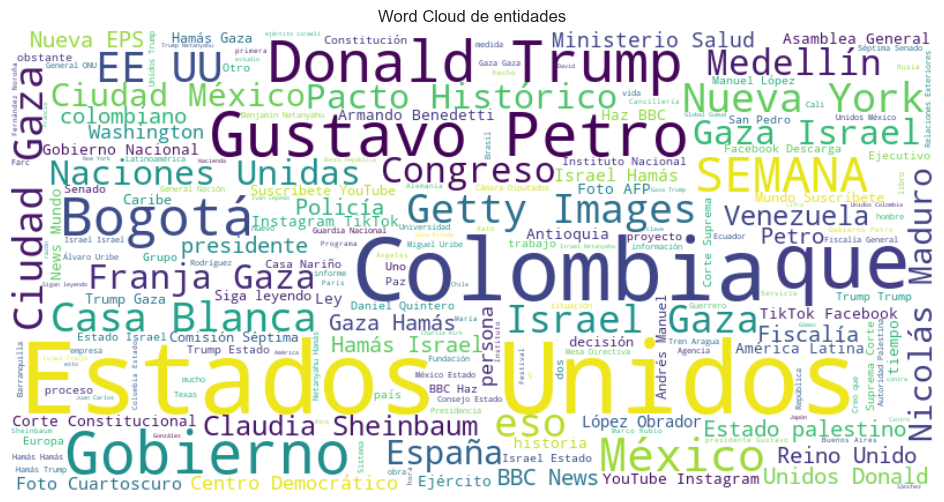

In [12]:
# Flatten entities, keep only the text part
all_entities = [ent[0] if isinstance(ent, tuple) else ent for sublist in df["entities"] for ent in sublist]

# Now you can join them for word cloud
text_for_wc = " ".join(all_entities)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_for_wc)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud de entidades")
plt.show()


In [13]:
selected_df = df[[
    "title",
    "category",
    "country",
    "newspaper",
    "content_removed_unwanted_elements_for_bert",
    "entities"
]].rename(columns={
    "content_removed_unwanted_elements_for_bert": "context"
})

selected_df.head()

,title,category,country,newspaper,context,entities
0,¿Qué enfermedad sufrió Gabriel García Márquez ...,cultura,Colombia,Semana,Se cumplen 10 años desde que Gabo falleció. El...,"[Gabo, mundo letras, Gabriel García Márquez, c..."
1,"“Tiburón: la historia de un clásico”, el docum...",cultura,Colombia,La El Colombiano,"A medio siglo de su estreno, Tiburón vuelve a ...","[Tiburón, National Geographic, Tiburón, Steven..."
2,El “boom” de la literatura latinoamericana rev...,cultura,Colombia,Semana,Décadas después del movimiento que convirtió a...,"[Décadas, Argentina, Chile, Eternauta, casa Es..."
3,Colombia brilló en Cannes: ‘Un Poeta’ ganó el ...,cultura,Colombia,Semana,La película de Simón Mesa Soto fue galardonada...,"[Simón Mesa Soto, Cierta Mirada Festival Canne..."
4,Este domingo en la FILBo habrá taller familiar...,cultura,Colombia,Semana,"Será un espacio para leer, soñar, reír y refle...","[domingo, Feria Internacional Libro Bogotá, FI..."


In [14]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [15]:
def filtrar_entidades_en_texto(entidades, contenido):
    """Mantener solo las entidades que aparecen en el contenido."""
    if not entidades:
        return []
    return [ent for ent in entidades if str(ent).lower() in contenido.lower()]

def generar_qa_factoid_imposible(contenido, titulo=None, entidades=None, categoria=None, periodico=None):
    """
    Genera pares de QA factoid y también preguntas imposibles en español.
    Devuelve una lista de diccionarios: question, answer, context, is_impossible
    """
    entidades_validas = filtrar_entidades_en_texto(entidades, contenido)

    prompt = f"""
Eres un generador de pares de preguntas y respuestas extractivas en español.
Genera 3-5 pares de QA factoid y 1-2 preguntas imposibles.
Usa solo las entidades que aparecen en el contenido.

Devuelve **únicamente** una lista JSON válida de objetos con los campos:
- "question": str
- "answer": str
- "is_impossible": bool

Ejemplo de formato:
[
  {{"question": "¿Qué país organizó la conferencia?", "answer": "Colombia", "is_impossible": false}},
  {{"question": "¿Quién dirigió la NASA?", "answer": "", "is_impossible": true}}
]

Datos del artículo:
Título: {titulo}
Categoría: {categoria}
Periódico: {periodico}
Entidades: {entidades_validas}
Contenido: {contenido}
"""

    response = client.chat.completions.create(
        model="gpt-4o-mini",  # or "gpt-5-mini"
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2,
    )

    raw_output = response.choices[0].message.content.strip()

    # Try to extract and parse JSON safely
    try:
        start = raw_output.find("[")
        end = raw_output.rfind("]") + 1
        json_str = raw_output[start:end]
        qa_pairs = json.loads(json_str)
        for qa in qa_pairs:
            qa["context"] = contenido
        return qa_pairs
    except Exception as e:
        print("Error generando QA:", e)
        print("Output del modelo:", raw_output)
        return []

In [16]:
# --- Tu DataFrame original (ejemplo) ---
# df = selected_df (ya filtrado)
# df.columns → ["title", "category", "country", "newspaper", "context", "entities"]

# 1️⃣ Filtrar filas con entidades no vacías
filtered_df = selected_df[
    (~selected_df["entities"].isna()) &
    (selected_df["entities"].astype(str).str.strip() != "")
]

In [17]:
# 2️⃣ Tomar una muestra aleatoria de 10
sample_df = filtered_df.sample(n=10, random_state=42)

# 3️⃣ Generar QA para cada fila
todos_qa = []

In [18]:
sample_df

,title,category,country,newspaper,context,entities
2830,Las exportaciones colombianas cayeron ligerame...,economia,Mexico,El Excelsior,Solo las ventas externas de productos agropecu...,"[Colombia, lunes, Departamento Administrativo ..."
315,Rels B puso a vibrar con su concierto en Bogot...,cultura,Colombia,Semana,El español no ocultó su felicidad al regresar ...,"[noches capital colombiana, Muchos llegan gran..."
2067,SAE se desmarca tras atentado en Antioquia que...,politica,Colombia,Semana,La entidad también señaló que varios predios b...,"[Sociedad Activos Especiales, Buriticá, Antioq..."
3536,Los hábitos y rasgos cotidianos que podrían al...,salud,Mexico,El Excelsior,La personalidad también podría estar escrita e...,"[estudio publicado, organizado, activo, Journa..."
439,¿Quiere estudiar desde casa? El Sena abrió 16....,economia,Colombia,La El Colombiano,La entidad amplió la fecha de inscripción hast...,"[36 técnicas, explicamos, nueva convocatoria, ..."
1454,Contraloría pone la lupa sobre el contrato de ...,judicial,Colombia,La El Espectador,El ente de control sigue de cerca un proceso d...,"[Colombia, Ejército Nacional, lupa, Contralorí..."
1725,Gustavo Petro compartió mensaje de reconocido ...,politica,Colombia,Semana,Las redes sociales reaccionaron a la publicaci...,"[martes, 30 septiembre, República, Gustavo Pet..."
676,Lotería de Bogotá: conozca los resultados del ...,economia,Colombia,El Tiempo,En la noche de este jueves la suerte podría es...,"[invitamos seguir sorteo vivo, Lotería Bogotá,..."
3522,Supersalud impone medida cautelar al FOMAG por...,salud,Mexico,El Excelsior,La Superintendencia de Salud ordenó al FOMAG d...,"[Superintendencia Salud, FOMAG, Superintendenc..."
3064,Julio César Chávez Jr. falta a audiencia en EU...,internacional,Mexico,Animal Politico,El boxeador mexicano Julio César Chávez Jr. no...,"[Julio César Chávez Jr, Estados Unidos, boxead..."


In [19]:
for _, row in sample_df.iterrows():
    qas = generar_qa_factoid_imposible(
        contenido=row["context"],
        titulo=row["title"],
        entidades=row["entities"],
        categoria=row["category"],
        periodico=row["newspaper"]
    )
    for qa in qas:
        qa["title"] = row["title"]
        qa["category"] = row["category"]
        qa["country"] = row["country"] if "country" in row else None
        qa["newspaper"] = row["newspaper"]
        qa["context"] = row["context"]
        qa["entities"] = row["entities"]
        todos_qa.append(qa)

# 4️⃣ Convertir a DataFrame final
qa_df = pd.DataFrame(todos_qa)
print(qa_df.head())

                                            question  \
0  ¿Cuánto sumaron las exportaciones colombianas ...   
1  ¿Qué entidad informó sobre las exportaciones c...   
2   ¿Cuál sector lideró las exportaciones en agosto?   
3  ¿Qué porcentaje de caída tuvieron las exportac...   
4  ¿Qué grupo de productos reportó un aumento en ...   

                                              answer  is_impossible  \
0                               USD 3.842,2 millones          False   
1                                               DANE          False   
2  el sector de combustibles y productos de las i...          False   
3                                                0,1          False   
4                 agropecuarios, alimentos y bebidas          False   

                                             context  \
0  Solo las ventas externas de productos agropecu...   
1  Solo las ventas externas de productos agropecu...   
2  Solo las ventas externas de productos agropecu...   
3  Solo las 

In [20]:
qa_df

,question,answer,is_impossible,context,title,category,country,newspaper,entities
0,¿Cuánto sumaron las exportaciones colombianas ...,"USD 3.842,2 millones",False,Solo las ventas externas de productos agropecu...,Las exportaciones colombianas cayeron ligerame...,economia,Mexico,El Excelsior,"[Colombia, lunes, Departamento Administrativo ..."
1,¿Qué entidad informó sobre las exportaciones c...,DANE,False,Solo las ventas externas de productos agropecu...,Las exportaciones colombianas cayeron ligerame...,economia,Mexico,El Excelsior,"[Colombia, lunes, Departamento Administrativo ..."
2,¿Cuál sector lideró las exportaciones en agosto?,el sector de combustibles y productos de las i...,False,Solo las ventas externas de productos agropecu...,Las exportaciones colombianas cayeron ligerame...,economia,Mexico,El Excelsior,"[Colombia, lunes, Departamento Administrativo ..."
3,¿Qué porcentaje de caída tuvieron las exportac...,"0,1",False,Solo las ventas externas de productos agropecu...,Las exportaciones colombianas cayeron ligerame...,economia,Mexico,El Excelsior,"[Colombia, lunes, Departamento Administrativo ..."
4,¿Qué grupo de productos reportó un aumento en ...,"agropecuarios, alimentos y bebidas",False,Solo las ventas externas de productos agropecu...,Las exportaciones colombianas cayeron ligerame...,economia,Mexico,El Excelsior,"[Colombia, lunes, Departamento Administrativo ..."
...,...,...,...,...,...,...,...,...,...
60,¿Qué organización está vinculada a las acusaci...,Cártel de Sinaloa,False,El boxeador mexicano Julio César Chávez Jr. no...,Julio César Chávez Jr. falta a audiencia en EU...,internacional,Mexico,Animal Politico,"[Julio César Chávez Jr, Estados Unidos, boxead..."
61,¿En qué ciudad fue detenido Julio César Chávez...,Los Ángeles,False,El boxeador mexicano Julio César Chávez Jr. no...,Julio César Chávez Jr. falta a audiencia en EU...,internacional,Mexico,Animal Politico,"[Julio César Chávez Jr, Estados Unidos, boxead..."
62,¿Qué fecha fue arrestado Julio César Chávez Jr.?,3 de julio,False,El boxeador mexicano Julio César Chávez Jr. no...,Julio César Chávez Jr. falta a audiencia en EU...,internacional,Mexico,Animal Politico,"[Julio César Chávez Jr, Estados Unidos, boxead..."
63,¿Cuál es el nombre del primer ministro de Isra...,Benjamin Netanyahu,False,El boxeador mexicano Julio César Chávez Jr. no...,Julio César Chávez Jr. falta a audiencia en EU...,internacional,Mexico,Animal Politico,"[Julio César Chávez Jr, Estados Unidos, boxead..."


In [21]:
qa_df["title"][30]

'¿Quiere estudiar desde casa? El Sena abrió 16.000 cupos para programas virtuales'

In [22]:
qa_df["newspaper"][30]

'La El Colombiano'

In [23]:
qa_df["category"][30]

'economia'

In [24]:
qa_df["context"][30]

'La entidad amplió la fecha de inscripción hasta este 29 de abril. Son 36 técnicas y tecnologías en modalidad virtual. Aquí le explicamos cómo aplicar. Una nueva convocatoria en este 2025 abrió el Servicio Nacional de Aprendizaje (Sena) para aquellas personas que quieran realizar su formación técnica o tecnológica en modalidad virtual. Hay 36 diferentes programas disponibles acordes a las necesidades actuales del mercado laboral en Colombia. Todavía tienes la oportunidad de formarte gratis con el SENA, gracias a la Segunda Oferta Virtual. Son 6 mil cupos para aplicar a uno de los 36 programas de nivel técnico y tecnólogo. No pierdas más tiempo y aprende a tu ritmo, describió la entidad. Para ello, solo se requiere: 1- Contactarse con un dispositivo con acceso a Internet. 2- Tener disponibilidad de al menos cuatro horas diarias para recibir clases virtuales. Técnicas: - Agente de tránsito y transporte. - Asesoría comercial. - Asistencia para la inteligencia empresarial. - Atención integ

In [25]:
qa_df["question"][30]

'¿Qué herramienta ofrece el Sena para quienes no tienen claridad sobre qué estudiar?'

In [26]:
qa_df["answer"][30]

'Test de Orientación Vocacional (IPO)'

In [27]:
GOLD_PATH   = "../datasets/exploration_datasets/gold/"

In [28]:
qa_df_total_data = []

for _, row in filtered_df.iterrows():
    qas = generar_qa_factoid_imposible(
        contenido=row["context"],
        titulo=row["title"],
        entidades=row["entities"],
        categoria=row["category"],
        periodico=row["newspaper"]
    )
    for qa in qas:
        qa["title"] = row["title"]
        qa["category"] = row["category"]
        qa["country"] = row["country"]
        qa["newspaper"] = row["newspaper"]
        qa["context"] = row["context"]
        qa["entities"] = row["entities"]
        qa_df_total_data.append(qa)

qa_df = pd.DataFrame(qa_df_total_data)
print(qa_df.columns)

Index(['question', 'answer', 'is_impossible', 'context', 'title', 'category',
       'country', 'newspaper', 'entities'],
      dtype='object')


In [31]:
qa_df.head()

,question,answer,is_impossible,context,title,category,country,newspaper,entities
0,¿Qué enfermedad padecía Gabriel García Márquez...,cáncer linfático,False,Se cumplen 10 años desde que Gabo falleció. El...,¿Qué enfermedad sufrió Gabriel García Márquez ...,cultura,Colombia,Semana,"[Gabo, mundo letras, Gabriel García Márquez, c..."
1,¿Dónde falleció Gabriel García Márquez?,en su casa en México,False,Se cumplen 10 años desde que Gabo falleció. El...,¿Qué enfermedad sufrió Gabriel García Márquez ...,cultura,Colombia,Semana,"[Gabo, mundo letras, Gabriel García Márquez, c..."
2,¿Qué obra maestra publicó García Márquez en 1967?,Cien años de soledad,False,Se cumplen 10 años desde que Gabo falleció. El...,¿Qué enfermedad sufrió Gabriel García Márquez ...,cultura,Colombia,Semana,"[Gabo, mundo letras, Gabriel García Márquez, c..."
3,¿Quién fue la abuela materna de Gabriel García...,Tranquilina Iguarán,False,Se cumplen 10 años desde que Gabo falleció. El...,¿Qué enfermedad sufrió Gabriel García Márquez ...,cultura,Colombia,Semana,"[Gabo, mundo letras, Gabriel García Márquez, c..."
4,¿Cuál es el nombre del pueblo ficticio donde s...,Macondo,False,Se cumplen 10 años desde que Gabo falleció. El...,¿Qué enfermedad sufrió Gabriel García Márquez ...,cultura,Colombia,Semana,"[Gabo, mundo letras, Gabriel García Márquez, c..."


In [33]:
qa_df.count()

question         23587
answer           23587
is_impossible    23587
context          23587
title            23587
category         23587
country          23587
newspaper        23587
entities         23587
dtype: int64

In [35]:
# 4️⃣ Save to file (you can pick one or both)
qa_df.to_csv(os.path.join(GOLD_PATH,"generated_qa_pairs.csv"), index=False, encoding="utf-8-sig")

In [38]:
qa_df.to_excel(os.path.join(GOLD_PATH,"generated_qa_pairs.xlsx"), index=False)

In [39]:
qa_df.to_json(os.path.join(GOLD_PATH,"generated_qa_pairs.json"), orient="records", lines=True)

In [40]:
qa_df.tail()

,question,answer,is_impossible,context,title,category,country,newspaper,entities
23582,¿En qué carretera se ha detectado mayormente e...,carretera 57,False,El titular de la Secretaría de Seguridad y Pro...,En 2023 han sido rescatados casi 900 migrantes...,seguridad,Mexico,El Universal,"[Secretaría Seguridad Protección Ciudadana, SS..."
23583,¿Qué tipo de vehículo se utilizó para traslada...,camioneta tipo Suburban,False,El titular de la Secretaría de Seguridad y Pro...,En 2023 han sido rescatados casi 900 migrantes...,seguridad,Mexico,El Universal,"[Secretaría Seguridad Protección Ciudadana, SS..."
23584,¿Cuántas personas viajaban en la camioneta tip...,13,False,El titular de la Secretaría de Seguridad y Pro...,En 2023 han sido rescatados casi 900 migrantes...,seguridad,Mexico,El Universal,"[Secretaría Seguridad Protección Ciudadana, SS..."
23585,¿Cuál es el nombre del funcionario que informó...,,True,El titular de la Secretaría de Seguridad y Pro...,En 2023 han sido rescatados casi 900 migrantes...,seguridad,Mexico,El Universal,"[Secretaría Seguridad Protección Ciudadana, SS..."
23586,¿Cuántos migrantes fueron rescatados en el mes...,,True,El titular de la Secretaría de Seguridad y Pro...,En 2023 han sido rescatados casi 900 migrantes...,seguridad,Mexico,El Universal,"[Secretaría Seguridad Protección Ciudadana, SS..."


In [ ]:
#with open(os.path.join(GOLD_PATH,"generated_qa_pairs.csv"), "w", encoding="utf-8") as f:
#    json.dump(qa_df_total_data, f, ensure_ascii=False, indent=2)